In [1]:
y_config = """params:
  mass: 1.3089969389957473e-12
  start: 0
  end: 1
  steps: 1000
  initial-conditions: [-1.5e-6, 0, 100.e-6, 0, 0, 0]

forces:
  - type: ray_tracer
    params:
      objects:
      - type: Sphere
        origin:
          type: offset
          value: [0,0,0]
        params:
          radius: 5.e-6
          n_in: 1.52
      ray-factory:
        type: AdaptiveGaussianRF
        origin:
          type: offset
          value: [0, 0, -5.e-6]
        params:
          waist_origin: [0, 0, 0]
          dir: [0,0,1]
          waist_radius: 3.39728e-6
          power: 300.e-3
          n: 1000
          wavelength: 532
          emit_radius: 5.e-6"""

In [31]:
import yaml
import forces.ray_tracer as rt
import tdt2
import ptracer as pt

import sys
sys.path.append("../old code")
import single_sphere_kim
import beam_intensity

%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
from tqdm.notebook import tqdm

# New code

In [3]:
config = yaml.safe_load(y_config)
sim_params = config["params"]
rtf = rt.factory(config, config["forces"][0]["params"])
rtf(config["params"]["initial-conditions"], 0)/config["params"]["mass"]

array([ 5.55311499e+01, -5.04570526e-15,  1.71616280e+02])

# Old code

In [4]:
class Inp:
    optical_switch = True
    target_n = config["forces"][0]["params"]["objects"][0]["params"]["n_in"]
    medium_n = 1
    polarisation='un_kim'
    target_radius = config["forces"][0]["params"]["objects"][0]["params"]["radius"]
    beam_type = "gaussian"
    W0 = config["forces"][0]["params"]["ray-factory"]["params"]["waist_radius"]
    wavelength = config["forces"][0]["params"]["ray-factory"]["params"]["wavelength"] * 1e-9
    power_profile = "constant"
    p_max = config["forces"][0]["params"]["ray-factory"]["params"]["power"]
    noise_switch = False
    c = 299792458
    target_abs = 0
inp = Inp()
single_sphere_kim.inp = inp
beam_intensity.inp = inp

In [5]:
init = config["params"]["initial-conditions"]
single_sphere_kim.optical_force(init[:3], 0)/config["params"]["mass"]

array([ 53.46362696,   0.        , 169.03925138])

# Compare intensities

In [6]:
waist_radius = 3.4e-6
wavelength = 532
z = 0
power = 300.e-3
r=0

w = waist_radius * np.sqrt(1 + ((z*wavelength*1e-9)/(np.pi*waist_radius**2))**2)
intensities = 2*power / (np.pi*w**2) * np.exp(-2 * r**2 / w ** 2)
print(intensities)

W=waist_radius*(1+((wavelength*1e-9*z)/(np.pi*waist_radius**2))**2)**0.5
I=((2.*power)/(np.pi*W**2.))*np.exp(-(2.*r**2.)/(W**2.))
print(I)

16521274369.4009
16521274369.4009


# Check weights

In [7]:
# rf = tdt2.AdaptiveGaussianRF(origin=[0,0], **config["forces"][0]["params"]["ray-factory"]["params"])
rf = pt.AdaptiveGaussianRF([0,0,0], [0,0,1], .5, 3, 100, 1, [0,0,0], 1)

In [8]:
np.sum(rf.weights) * 6.62607004e-25 * 299792458 / rf.wavelength

3.061650397696569

# Compare x dependedce

<IPython.core.display.Javascript object>


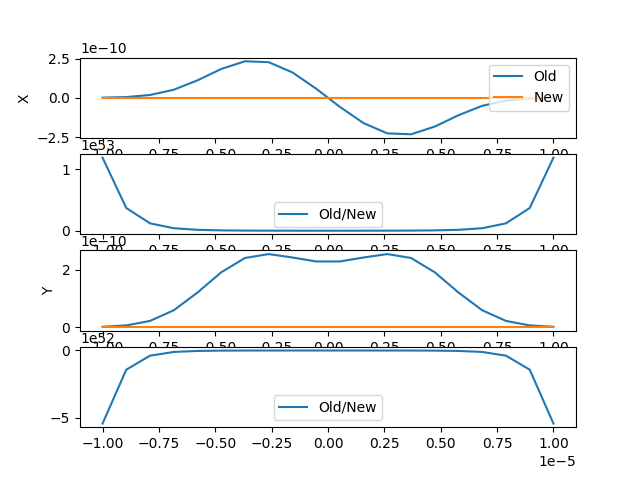

In [9]:
fig, ax = plt.subplots(4)
w = 10e-6
xs = np.linspace(-w, w, 20)
y = 30e-6
old_f = []
new_f = []
for x in xs:
    old_f.append(single_sphere_kim.optical_force([x, 0, y], 0))
    new_f.append(rtf([x, y, 0, 0], 0))
old_f = np.array(old_f)
new_f = np.array(new_f)

ax[0].plot(xs, old_f[:,0], label="Old")
ax[0].plot(xs, new_f[:,0], label="New")
ax[0].legend()
ax[0].set_ylabel("X")

ax[1].plot(xs, old_f[:,0]/new_f[:,0], label="Old/New")
ax[1].legend()

ax[2].plot(xs, old_f[:,2])
ax[2].plot(xs, new_f[:,1])
ax[2].set_ylabel("Y")

ax[3].plot(xs, old_f[:,2]/new_f[:,1], label="Old/New")
ax[3].legend()

plt.show()

# 3D version

In [10]:
reload(pt)

<module 'ptracer' from '/home/jdranczewski/Documents/Imperial/UROP20/optical-levitation-raytracing-experiments/ptracer.py'>

In [77]:
def ptforce(state, t):
    params = config["forces"][0]["params"]
    rfo = state[:3] + np.array([0, 0, -5.1e-6])
#     print(rfo)
    rf = pt.AdaptiveGaussianRF([0,0,0], [0,0,1], 3.4e-6, 300e-3, 1000, 532, rfo, 5e-6)
    
    sphere = pt.Sphere(state[:3], 5.e-6, n_in=1.52)
    
    scene = pt.Scene(rf, [sphere])
    scene.run()
#     scene.propagate(1)
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     scene.plot(ax)
    return scene.momentum*6.62607004e-34*1e9

In [78]:
def ptforce_curve(state, t):
    params = config["forces"][0]["params"]
    rfo = state[:3] + np.array([0, 0, -5.1e-6])
#     print(rfo)
    rf = pt.AdaptiveGaussianRF([0,0,0], [0,0,1], 3.4e-6, 300e-3, 1000, 532, rfo, 5e-6, curve=True)
    
    sphere = pt.Sphere(state[:3], 5.e-6, n_in=1.52)
    
    scene = pt.Scene(rf, [sphere])
    scene.run()
#     scene.propagate(1)
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     scene.plot(ax)
    return scene.momentum*6.62607004e-34*1e9

In [79]:
ptforce([0, 0, 0, 0, 0, 0], 0)

array([-1.46390183e-26, -3.53128832e-28,  2.18822877e-10])

In [80]:
ptforce([init[0], 0, init[1]], 0)

array([1.63227137e-10, 4.66406590e-27, 2.38665446e-10])

# Compare x again

<IPython.core.display.Javascript object>


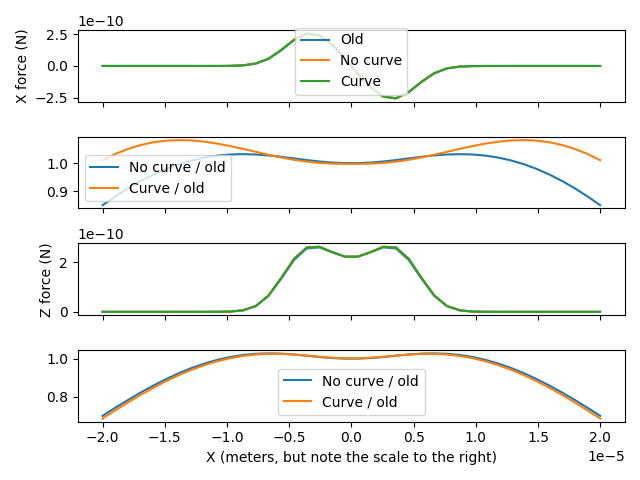

In [81]:
fig, ax = plt.subplots(4, sharex=True)
w = 20e-6
xs = np.linspace(-w, w, 40)
y = 1e-5
old_f = []
new_f = []
pt3_f = []
for x in xs:
    old_f.append(single_sphere_kim.optical_force([x, 0, y], 0))
    new_f.append(ptforce([x, 0, y, 0, 0, 0], 0))
    pt3_f.append(ptforce_curve([x, 0, y, 0, 0, 0], 0))
old_f = np.array(old_f)
new_f = np.array(new_f)
pt3_f = np.array(pt3_f)

ax[0].plot(xs, old_f[:,0], label="Old")
ax[0].plot(xs, new_f[:,0], label="No curve")
ax[0].plot(xs, pt3_f[:,0], label="Curve")
ax[0].legend()
ax[0].set_ylabel("X force (N)")

ax[1].plot(xs, new_f[:,0]/old_f[:,0], label="No curve / old")
ax[1].plot(xs, pt3_f[:,0]/old_f[:,0], label="Curve / old")
ax[1].legend()

ax[2].plot(xs, old_f[:,2])
ax[2].plot(xs, new_f[:,2])
ax[2].plot(xs, pt3_f[:,2])
ax[2].set_ylabel("Z force (N)")

ax[3].plot(xs, new_f[:,2]/old_f[:,2], label="No curve / old")
ax[3].plot(xs, pt3_f[:,2]/old_f[:,2], label="Curve / old")
ax[3].legend()
ax[3].set_xlabel("X (meters, but note the scale to the right)")

plt.tight_layout()
plt.show()

# Mesh vs sphere

<IPython.core.display.Javascript object>


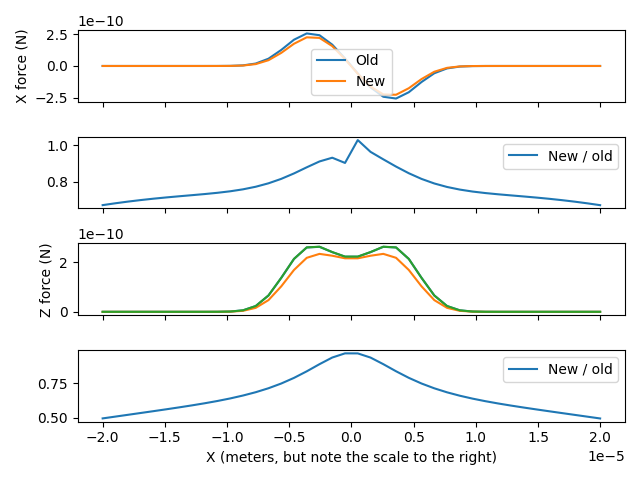

In [91]:
fig, ax = plt.subplots(4, sharex=True)
w = 20e-6
xs = np.linspace(-w, w, 40)
y = 1e-5
old_f = []
new_f = []
for x in tqdm(xs):
    old_f.append(ptforce([x, 0, y, 0, 0, 0], 0))
    new_f.append(mesh_force([x, 0, y, 0, 0, 0], 0))
old_f = np.array(old_f)
new_f = np.array(new_f)

ax[0].plot(xs, old_f[:,0], label="Old")
ax[0].plot(xs, new_f[:,0], label="New")
ax[0].legend()
ax[0].set_ylabel("X force (N)")

ax[1].plot(xs, new_f[:,0]/old_f[:,0], label="New / old")
ax[1].legend()

ax[2].plot(xs, old_f[:,2])
ax[2].plot(xs, new_f[:,2])
ax[2].plot(xs, pt3_f[:,2])
ax[2].set_ylabel("Z force (N)")

ax[3].plot(xs, new_f[:,2]/old_f[:,2], label="New / old")
ax[3].legend()
ax[3].set_xlabel("X (meters, but note the scale to the right)")

plt.tight_layout()
plt.show()

In [87]:
def mesh_force(state, t):
    params = config["forces"][0]["params"]
    rfo = state[:3] + np.array([0, 0, -5.1e-6])
    rf = pt.AdaptiveGaussianRF([0,0,0], [0,0,1], 3.4e-6, 300e-3, 300, 532, rfo, 5e-6, curve=False)
    
    sphere = pt.Mesh(state[:3], "cruel_sphere.obj", 5.e-6, n_in=1.52)
    
    scene = pt.Scene(rf, [sphere])
    scene.run(limit=5)
#     scene.propagate(1e-6)
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     scene.plot(ax)
    return scene.momentum*6.62607004e-34*1e9

In [88]:
mesh_force([0, 0, 0, 0, 0, 0], 0)

array([-3.85327989e-12, -2.07671328e-13,  2.13312538e-10])

In [89]:
%timeit ptforce([0, 0, 0, 0, 0, 0], 0)

7.3 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [90]:
%timeit mesh_force([0, 0, 0, 0, 0, 0], 0)

625 ms ± 29.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
